## Import necessary libraries and setup

In [ ]:
"""

Author: Vaibhav Sharma, Shreya Khantal, Prasanna Saxena
Team Name: Team Cygnus
Team Members: Vaibhav Sharma, Shreya Khantal, Prasanna Saxena
Public Leaderboard Rank: 20
"""



# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import tempfile  # Add this import
import shutil    # Add this import

# For PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import torch.nn.functional as F

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Load and examine the data

In [ ]:
# Load CSVs and set up paths
train_df = pd.read_csv("/kaggle/input/soil-classification-part-2/soil_competition-2025/train_labels.csv")
test_df = pd.read_csv("/kaggle/input/soil-classification-part-2/soil_competition-2025/test_ids.csv")
sample_submission = pd.read_csv("/kaggle/input/soil-classification-part-2/soil_competition-2025/sample_submission.csv")

# Define paths
train_img_dir = "/kaggle/input/soil-classification-part-2/soil_competition-2025/train"
test_img_dir = "/kaggle/input/soil-classification-part-2/soil_competition-2025/test"

# Add full file paths
train_df["file_path"] = train_df["image_id"].apply(lambda x: os.path.join(train_img_dir, x))
test_df["file_path"] = test_df["image_id"].apply(lambda x: os.path.join(test_img_dir, x))

## Analyze class distribution

Train shape: (1222, 3)
Test shape: (967, 2)
Sample Submission shape: (4, 2)

Missing values in train set:
 image_id     0
label        0
file_path    0
dtype: int64

Missing values in test set:
 image_id     0
file_path    0
dtype: int64

Label distribution in training set:
 label
1    1222
Name: count, dtype: int64


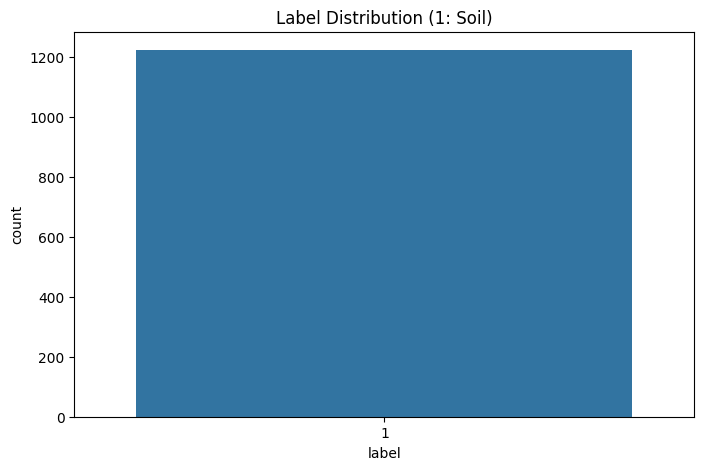

⚠️ WARNING: No non-soil images (label 0) found in training data!
We'll need to address this class imbalance issue.


In [ ]:
# Basic Dataset Information
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Sample Submission shape:", sample_submission.shape)

# Check for missing values
print("\nMissing values in train set:\n", train_df.isnull().sum())
print("\nMissing values in test set:\n", test_df.isnull().sum())

# Check label distribution
label_counts = train_df['label'].value_counts()
print("\nLabel distribution in training set:\n", label_counts)

# Visualize label distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='label')
plt.title("Label Distribution (1: Soil)")
plt.show()

# Check if we have any non-soil images (label 0)
if 0 not in label_counts.index:
    print("⚠️ WARNING: No non-soil images (label 0) found in training data!")
    print("We'll need to address this class imbalance issue.")

## Visualize sample images from each soil type

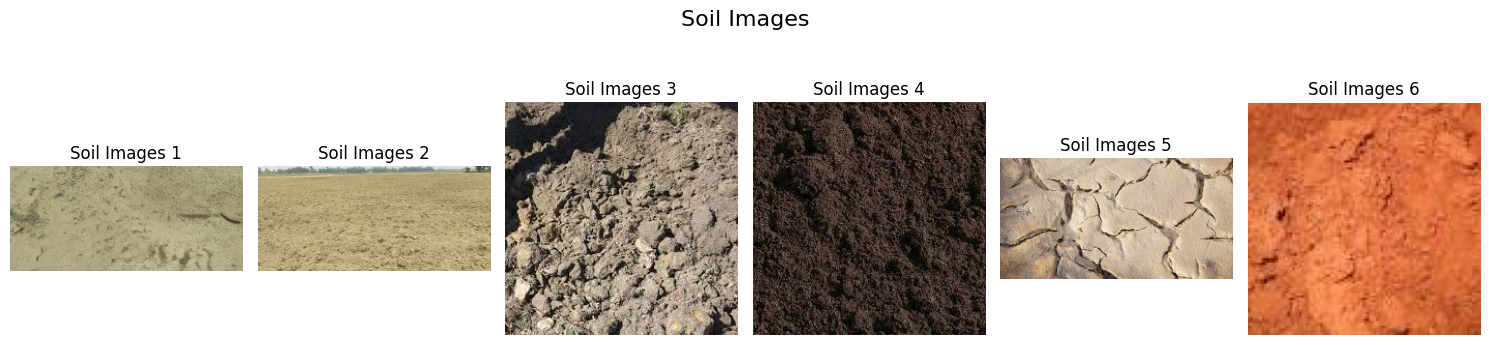

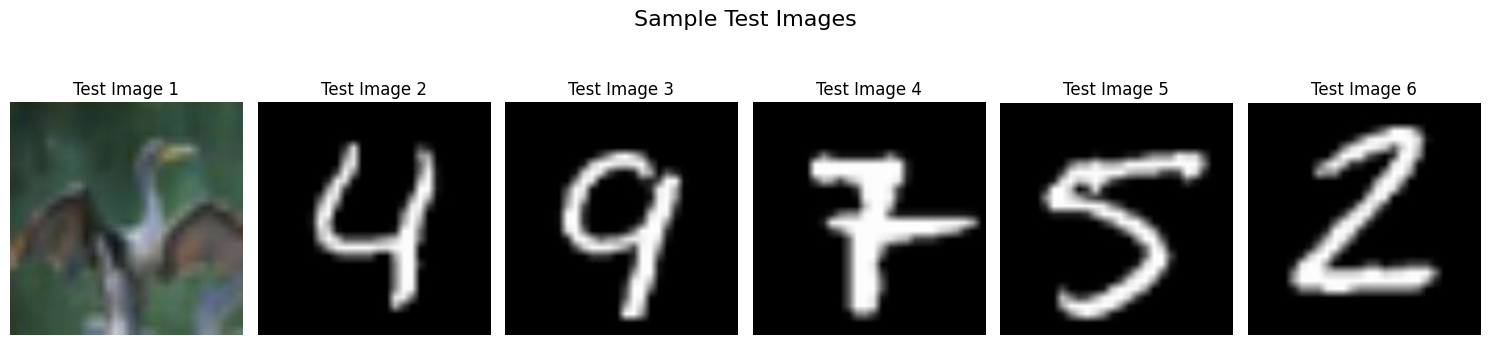

In [ ]:
# Visualize Sample Images
def plot_images(df, label, title, n=6):
    subset = df[df['label'] == label] if 'label' in df.columns else df
    if subset.empty:
        print(f"⚠️ No images found for label {label} ({title})")
        return
    
    sample_df = subset.sample(min(n, len(subset)))
    plt.figure(figsize=(15, 4))
    
    for i, row in enumerate(sample_df.iterrows()):
        try:
            img = Image.open(row[1]['file_path'])
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{title} {i+1}")
        except Exception as e:
            print(f"Error loading image {row[1]['file_path']}: {e}")
    
    plt.suptitle(f"{title}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Display sample soil images
plot_images(train_df, label=1, title="Soil Images")

# For test images (no labels)
plt.figure(figsize=(15, 4))
for i, row in enumerate(test_df.sample(6).iterrows()):
    try:
        img = Image.open(row[1]['file_path'])
        plt.subplot(1, 6, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Test Image {i+1}")
    except Exception as e:
        print(f"Error loading image {row[1]['file_path']}: {e}")
plt.suptitle("Sample Test Images", fontsize=16)
plt.tight_layout()
plt.show()

## Analyze image dimensions

Analyzing 300 random training images...


  0%|          | 0/300 [00:00<?, ?it/s]


Corrupt images: 0 (0.00% of sample)

Image Dimension Statistics:
             width       height
count   300.000000   300.000000
mean    633.320000   405.243333
std     459.077238   275.474229
min     100.000000    57.000000
25%     272.000000   183.000000
50%     393.000000   280.000000
75%    1160.000000   522.000000
max    2592.000000  1920.000000

Image Channels:
channels
3    297
4      2
1      1
Name: count, dtype: int64

Image Formats:
format
JPEG    287
WEBP     10
PNG       3
Name: count, dtype: int64

Image Modes:
mode
RGB     297
RGBA      2
P         1
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


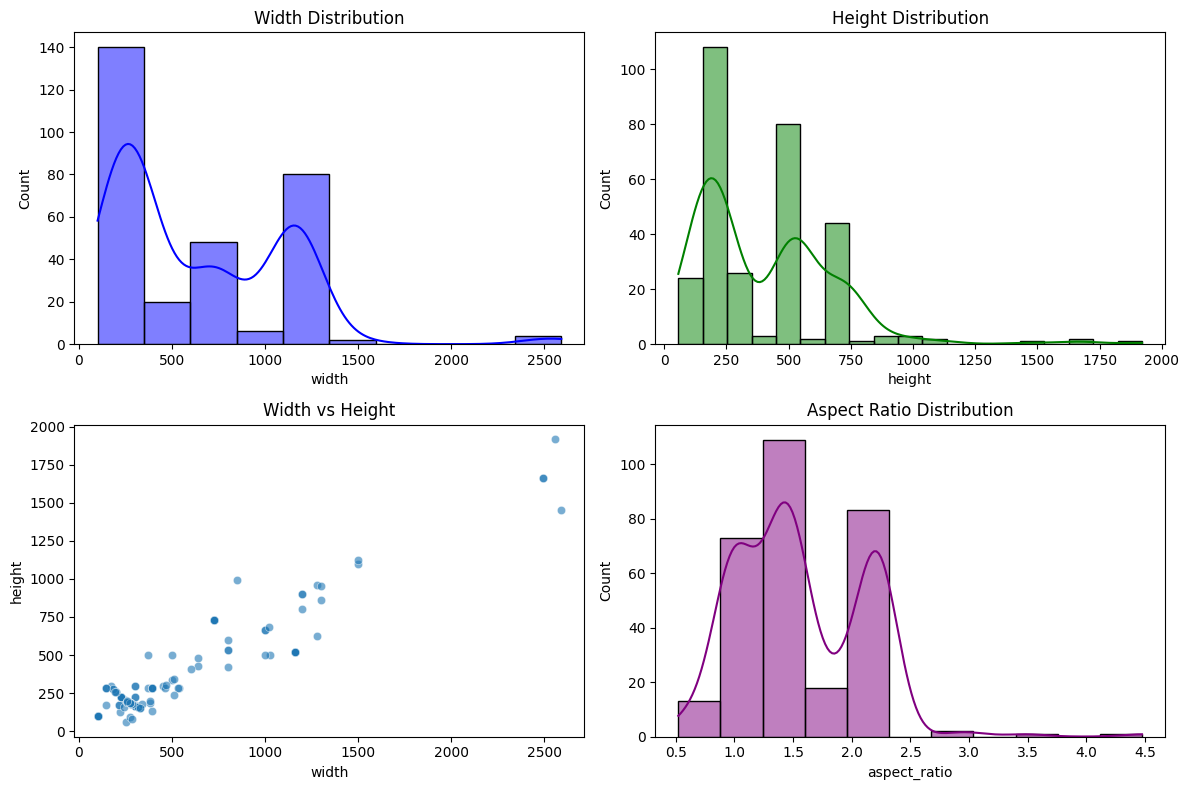


Smallest images (by area):
6     100
25    100
62    100
69    100
78    100
Name: width, dtype: int64

Largest images (by area):
90     2592
123    2560
32     2496
37     2496
107    1500
Name: width, dtype: int64


In [ ]:
# Function to get image info
def get_image_info(path):
    try:
        img = Image.open(path)
        return {
            'width': img.size[0],
            'height': img.size[1],
            'aspect_ratio': img.size[0] / img.size[1],
            'channels': len(img.getbands()),
            'format': img.format,
            'mode': img.mode,
            'corrupt': False
        }
    except Exception as e:
        print(f"Error with image {path}: {e}")
        return {
            'width': 0, 'height': 0, 'aspect_ratio': 0,
            'channels': 0, 'format': None, 'mode': None, 'corrupt': True
        }

# Sample a subset of images for analysis
sample_size = min(300, len(train_df))
print(f"Analyzing {sample_size} random training images...")

image_properties = []
for path in tqdm(train_df["file_path"].sample(sample_size)):
    image_properties.append(get_image_info(path))

image_df = pd.DataFrame(image_properties)

# Check for corrupt images
corrupt_count = image_df['corrupt'].sum()
print(f"\nCorrupt images: {corrupt_count} ({corrupt_count/sample_size:.2%} of sample)")

# Remove corrupt entries for analysis
image_df = image_df[~image_df['corrupt']]

# Basic statistics of image dimensions
print("\nImage Dimension Statistics:")
print(image_df[['width', 'height']].describe())

# Channel and format analysis
print("\nImage Channels:")
print(image_df['channels'].value_counts())

print("\nImage Formats:")
print(image_df['format'].value_counts())

print("\nImage Modes:")
print(image_df['mode'].value_counts())

# Visualize dimensions
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(image_df['width'], kde=True, color='blue')
plt.title('Width Distribution')

plt.subplot(2, 2, 2)
sns.histplot(image_df['height'], kde=True, color='green')
plt.title('Height Distribution')

plt.subplot(2, 2, 3)
sns.scatterplot(data=image_df, x='width', y='height', alpha=0.6)
plt.title('Width vs Height')

plt.subplot(2, 2, 4)
sns.histplot(image_df['aspect_ratio'], kde=True, color='purple')
plt.title('Aspect Ratio Distribution')

plt.tight_layout()
plt.show()

# Check for anomalies - extremely small or large images
print("\nSmallest images (by area):")
print(image_df.nsmallest(5, 'width')['width'])

print("\nLargest images (by area):")
print(image_df.nlargest(5, 'width')['width'])

## Analyze color distribution by soil type

In [ ]:
# Color Analysis - Calculate average color profiles
def get_avg_color_profile(sample_paths, n_samples=50):
    """Calculate average color statistics across samples"""
    
    r_means, g_means, b_means = [], [], []
    r_stds, g_stds, b_stds = [], [], []
    
    for path in tqdm(sample_paths[:n_samples]):
        try:
            img = Image.open(path).convert('RGB')
            img_array = np.array(img)
            
            # Calculate means and stds for each channel
            r_means.append(img_array[:,:,0].mean())
            g_means.append(img_array[:,:,1].mean())
            b_means.append(img_array[:,:,2].mean())
            
            r_stds.append(img_array[:,:,0].std())
            g_stds.append(img_array[:,:,1].std())
            b_stds.append(img_array[:,:,2].std())
            
        except Exception as e:
            print(f"Error processing {path}: {e}")
    
    return {
        'r_mean': np.mean(r_means), 'g_mean': np.mean(g_means), 'b_mean': np.mean(b_means),
        'r_std': np.mean(r_stds), 'g_std': np.mean(g_stds), 'b_std': np.mean(b_stds)
    }

# Calculate average color profiles for normalization
color_sample_paths = train_df['file_path'].sample(50).tolist()
avg_color_profile = get_avg_color_profile(color_sample_paths)

print("\nAverage Color Profile for Soil Images:")
for key, value in avg_color_profile.items():
    print(f"{key}: {value:.2f}")

  0%|          | 0/50 [00:00<?, ?it/s]


Average Color Profile for Soil Images:
r_mean: 124.35
g_mean: 101.69
b_mean: 78.92
r_std: 38.10
g_std: 37.26
b_std: 36.08


## Creation of Synthetic Non-Soil Images

Creating synthetic non-soil images...


  0%|          | 0/100 [00:00<?, ?it/s]

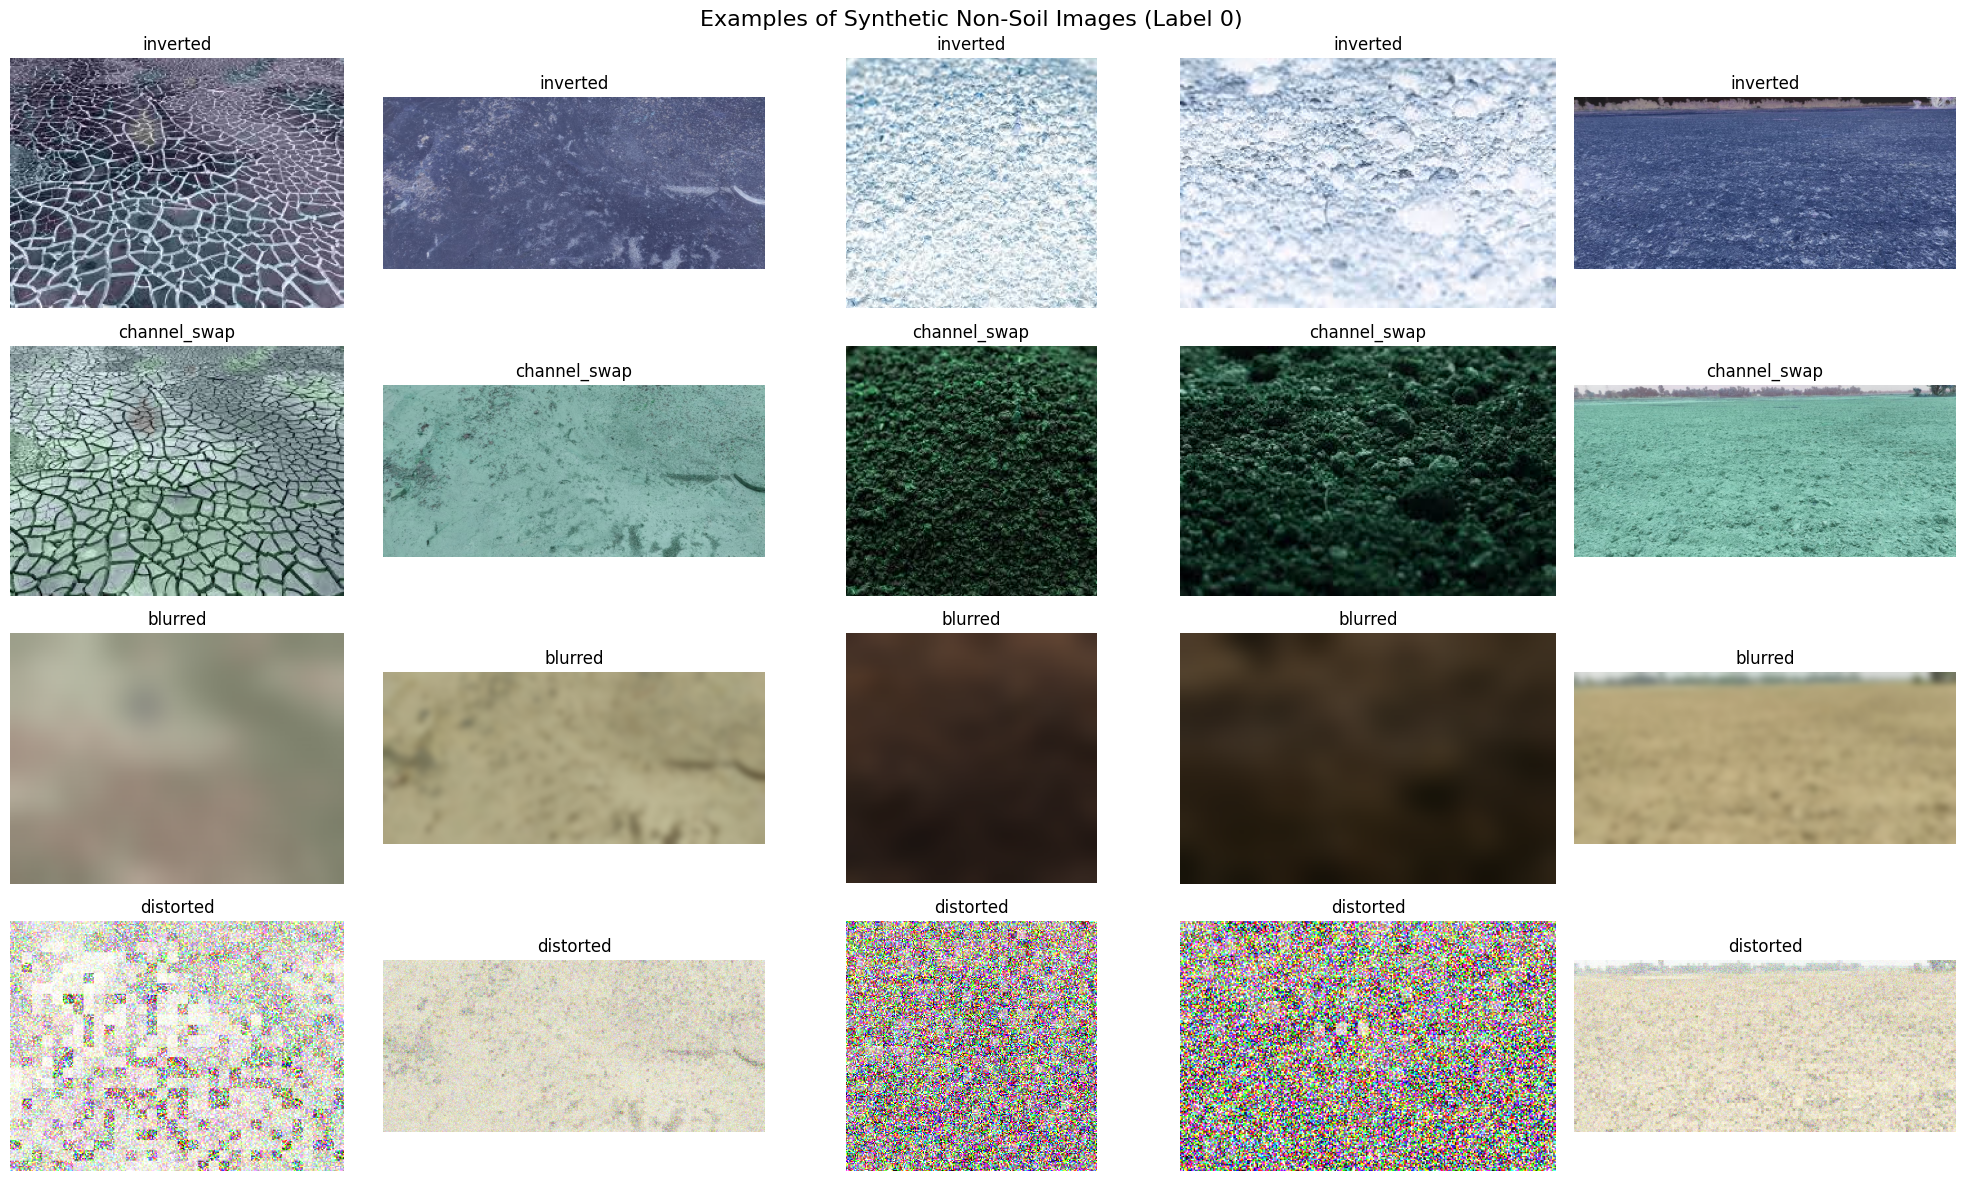

Created 400 synthetic non-soil images
Created temporary directory: /tmp/tmp2qlqplz6


0it [00:00, ?it/s]


Balanced dataset label distribution:
label
1    1222
0     400
Name: count, dtype: int64


In [ ]:
# Since we only have soil images (label 1), we need to create non-soil examples (label 0)
def create_synthetic_non_soil_images(soil_df, num_synthetic=400):
    """
    Create synthetic non-soil images based on real soil images.
    Techniques:
    1. Color inversion
    2. Channel swapping
    3. Heavy blurring
    4. Texture distortion
    """
    print("Creating synthetic non-soil images...")
    
    synthetic_data = []
    soil_samples = soil_df.sample(num_synthetic // 4).reset_index(drop=True)
    
    for idx, row in tqdm(soil_samples.iterrows(), total=len(soil_samples)):
        try:
            # Load original soil image
            img = cv2.imread(row['file_path'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # 1. Inverted colors (negative)
            inverted = 255 - img
            synthetic_data.append({
                'image_id': f"synthetic_inv_{idx}.jpg",
                'label': 0,
                'image': inverted,
                'type': 'inverted'
            })
            
            # 2. Channel swapping (BGR instead of RGB)
            swapped = img.copy()
            swapped[:,:,[0,1,2]] = swapped[:,:,[2,0,1]]  # RGB -> BRG
            synthetic_data.append({
                'image_id': f"synthetic_swap_{idx}.jpg",
                'label': 0,
                'image': swapped,
                'type': 'channel_swap'
            })
            
            # 3. Heavy blurring
            blurred = cv2.GaussianBlur(img, (51, 51), 10)
            synthetic_data.append({
                'image_id': f"synthetic_blur_{idx}.jpg",
                'label': 0,
                'image': blurred,
                'type': 'blurred'
            })
            
            # 4. Texture distortion (pixelation + noise)
            h, w = img.shape[:2]
            small = cv2.resize(img, (w//8, h//8))
            pixelated = cv2.resize(small, (w, h), interpolation=cv2.INTER_NEAREST)
            noise = np.random.normal(0, 25, pixelated.shape).astype(np.uint8)
            distorted = cv2.add(pixelated, noise)
            synthetic_data.append({
                'image_id': f"synthetic_dist_{idx}.jpg",
                'label': 0,
                'image': distorted,
                'type': 'distorted'
            })
            
        except Exception as e:
            print(f"Error creating synthetic image for {row['file_path']}: {e}")
    
    # Create dataframe with synthetic data
    synthetic_df = pd.DataFrame(synthetic_data)
    
    # Visualize examples of synthetic non-soil images
    plt.figure(figsize=(20, 12))
    
    for i, img_type in enumerate(['inverted', 'channel_swap', 'blurred', 'distorted']):
        subset = synthetic_df[synthetic_df['type'] == img_type].head(5)
        
        for j, (_, row) in enumerate(subset.iterrows()):
            plt.subplot(4, 5, i*5 + j + 1)
            plt.imshow(row['image'])
            plt.title(f"{row['type']}")
            plt.axis('off')
    
    plt.suptitle("Examples of Synthetic Non-Soil Images (Label 0)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print(f"Created {len(synthetic_df)} synthetic non-soil images")
    return synthetic_df

# Create synthetic non-soil images
synthetic_df = create_synthetic_non_soil_images(train_df)

# Save synthetic images to temporary files
temp_dir = tempfile.mkdtemp()
print(f"Created temporary directory: {temp_dir}")

# Save synthetic images
for _, row in tqdm(synthetic_df.iterrows()):
    img_path = os.path.join(temp_dir, row['image_id'])
    cv2.imwrite(img_path, cv2.cvtColor(row['image'], cv2.COLOR_RGB2BGR))
    synthetic_df.loc[_, 'file_path'] = img_path

# Create balanced dataset with real soil and synthetic non-soil images
balanced_df = pd.DataFrame({
    'image_id': train_df['image_id'].tolist() + synthetic_df['image_id'].tolist(),
    'label': train_df['label'].tolist() + synthetic_df['label'].tolist(),
    'file_path': train_df['file_path'].tolist() + synthetic_df['file_path'].tolist()
})

# Check the balance
print("\nBalanced dataset label distribution:")
print(balanced_df['label'].value_counts())

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

## Define dataset class and transformations

In [ ]:
# Create Custom PyTorch Dataset and DataLoaders
class SoilImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, is_test=False):
        self.dataframe = dataframe
        self.transform = transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        img = Image.open(img_path).convert('RGB')
            
        if self.transform:
            img = self.transform(img)
            
        # For test set, we don't have labels
        if self.is_test:
            return img, 0  # Dummy label that won't be used
        else:
            label = self.dataframe.iloc[idx]['label']
            return img, label

# Define transforms for training and validation
def get_transforms(img_size=224):
    """Define image transformations for training and validation"""
    
    # Calculate mean and std from the color analysis
    mean = [avg_color_profile['r_mean']/255, avg_color_profile['g_mean']/255, avg_color_profile['b_mean']/255]
    std = [avg_color_profile['r_std']/255, avg_color_profile['g_std']/255, avg_color_profile['b_std']/255]
    
    # Fall back to ImageNet means and stds if needed
    if np.isnan(mean).any() or np.isnan(std).any():
        mean = [0.485, 0.456, 0.406]  # ImageNet means
        std = [0.229, 0.224, 0.225]   # ImageNet stds
    
    # Training transforms with augmentation
    train_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    
    # Validation/Test transforms (no augmentation)
    val_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    
    return train_transforms, val_transforms

## HYPER PARAMETER TUNING USING 5 FOLD GRID SEARCH CROSS VALIDATION - COMMENTED OUT

In [ ]:
# # Cross-Validation
# # Let's use stratified K-fold cross-validation to get a more robust estimate
# def perform_cross_validation(model_class, balanced_df, n_splits=5, img_size=224, model_name='resnet18'):
#     """
#     Perform stratified k-fold cross-validation
    
#     Args:
#         model_class: Model class to use
#         balanced_df: Dataframe with balanced data
#         n_splits: Number of CV folds
        
#     Returns:
#         cv_results: Dictionary with cross-validation metrics
#     """
#     # Initialize cross-validation
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
#     # Setup transforms
#     train_transforms, val_transforms = get_transforms(img_size=img_size)
    
#     # Track metrics
#     cv_results = {
#         'val_acc': [],
#         'val_f1': [],
#         'val_loss': [],
#         'confusion_matrices': []
#     }
    
#     # Loop through folds
#     for fold, (train_idx, val_idx) in enumerate(skf.split(balanced_df, balanced_df['label'])):
#         print(f"Fold {fold+1}/{n_splits}")
#         print('-' * 30)
        
#         # Split data
#         train_fold = balanced_df.iloc[train_idx].reset_index(drop=True)
#         val_fold = balanced_df.iloc[val_idx].reset_index(drop=True)
        
#         # Create datasets
#         train_dataset = SoilImageDataset(train_fold, transform=train_transforms)
#         val_dataset = SoilImageDataset(val_fold, transform=val_transforms)
        
#         # Create dataloaders
#         train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
#         val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
        
#         # Initialize model
#         model = model_class(model_name=model_name, pretrained=True)
#         model = model.to(device)
        
#         # Setup loss and optimizer
#         criterion = nn.CrossEntropyLoss()
#         optimizer = optim.Adam(model.parameters(), lr=0.001)
#         scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
        
#         # Train for fewer epochs in CV
#         num_epochs = 5
#         model, fold_history = train_model(
#             model, train_loader, val_loader,
#             criterion, optimizer, scheduler,
#             num_epochs=num_epochs
#         )
        
#         # Evaluate on validation set
#         model.eval()
#         val_loss = 0.0
#         all_preds = []
#         all_labels = []
        
#         with torch.no_grad():
#             for inputs, labels in tqdm(val_loader, desc='Validation'):
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)
                
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels)
                
#                 val_loss += loss.item() * inputs.size(0)
#                 all_preds.extend(preds.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())
        
#         # Calculate metrics
#         val_loss = val_loss / len(val_loader.dataset)
#         val_acc = accuracy_score(all_labels, all_preds)
#         val_f1 = f1_score(all_labels, all_preds, average='binary')
#         cm = confusion_matrix(all_labels, all_preds)
        
#         # Store results
#         cv_results['val_acc'].append(val_acc)
#         cv_results['val_f1'].append(val_f1)
#         cv_results['val_loss'].append(val_loss)
#         cv_results['confusion_matrices'].append(cm)
        
#         print(f"Fold {fold+1} - Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}")
#         print(f"Confusion Matrix:\n{cm}")
#         print()
    
#     # Calculate average metrics
#     avg_acc = np.mean(cv_results['val_acc'])
#     avg_f1 = np.mean(cv_results['val_f1'])
#     avg_loss = np.mean(cv_results['val_loss'])
    
#     print(f"Cross-Validation Results:")
#     print(f"Average Validation Loss: {avg_loss:.4f}")
#     print(f"Average Validation Accuracy: {avg_acc:.4f}")
#     print(f"Average Validation F1 Score: {avg_f1:.4f}")
    
#     # Plot confusion matrices
#     plt.figure(figsize=(15, 10))
#     for i, cm in enumerate(cv_results['confusion_matrices']):
#         plt.subplot(2, 3, i+1)
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#         plt.title(f"Fold {i+1}")
#         plt.xlabel('Predicted')
#         plt.ylabel('Actual')
    
#     plt.tight_layout()
#     plt.show()
    
#     return cv_results

# # Perform cross-validation
# cv_results = perform_cross_validation(SoilClassifier, balanced_df, n_splits=5, model_name='resnet18')

# # Model Evaluation and Hyperparameter Tuning
# # Let's try a simple grid search on key hyperparameters
# def grid_search(model_class, balanced_df):
#     """
#     Simple grid search for hyperparameter tuning
    
#     Args:
#         model_class: Model class to use
#         balanced_df: Balanced dataframe
        
#     Returns:
#         best_params: Best hyperparameters
#         grid_results: Results for each combination
#     """
#     # Define parameter grid
#     param_grid = {
#         'model_name': ['resnet18', 'mobilenet_v3_small'],
#         'learning_rate': [0.001, 0.0005],
#         'img_size': [224]  # Keep this fixed for simplicity
#     }
    
#     # Store results
#     grid_results = []
    
#     # Split data once for grid search
#     train_df, val_df = train_test_split(
#         balanced_df, 
#         test_size=0.2, 
#         stratify=balanced_df['label'],
#         random_state=42
#     )
    
#     # Try all combinations
#     for model_name in param_grid['model_name']:
#         for lr in param_grid['learning_rate']:
#             for img_size in param_grid['img_size']:
#                 print(f"Testing: model={model_name}, lr={lr}, img_size={img_size}")
                
#                 # Setup transforms
#                 train_transforms, val_transforms = get_transforms(img_size=img_size)
                
#                 # Create datasets
#                 train_dataset = SoilImageDataset(train_df, transform=train_transforms)
#                 val_dataset = SoilImageDataset(val_df, transform=val_transforms)
                
#                 # Create dataloaders
#                 train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
#                 val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
                
#                 # Initialize model
#                 model = model_class(model_name=model_name, pretrained=True)
#                 model = model.to(device)
                
#                 # Setup loss and optimizer
#                 criterion = nn.CrossEntropyLoss()
#                 optimizer = optim.Adam(model.parameters(), lr=lr)
                
#                 # Train for fewer epochs in grid search
#                 num_epochs = 3
#                 model, history = train_model(
#                     model, train_loader, val_loader,
#                     criterion, optimizer, None,
#                     num_epochs=num_epochs
#                 )
                
#                 # Get best validation F1 score
#                 best_val_f1 = max(history['val_f1'])
                
#                 # Store results
#                 grid_results.append({
#                     'model_name': model_name,
#                     'learning_rate': lr,
#                     'img_size': img_size,
#                     'best_val_f1': best_val_f1
#                 })
    
#     # Find best parameters
#     grid_df = pd.DataFrame(grid_results)
#     best_idx = grid_df['best_val_f1'].idxmax()
#     best_params = grid_df.iloc[best_idx].to_dict()
    
#     print("\nGrid Search Results:")
#     print(grid_df.sort_values('best_val_f1', ascending=False))
    
#     print("\nBest Parameters:")
#     for param, value in best_params.items():
#         print(f"{param}: {value}")
    
#     return best_params, grid_df

# # Run grid search
# best_params, grid_results = grid_search(SoilClassifier, balanced_df)

## Create and train model

In [ ]:
# Define Model Architecture
class SoilClassifier(nn.Module):
    def __init__(self, model_name='resnet18', pretrained=True):
        super(SoilClassifier, self).__init__()
        
        # Load pre-trained model
        if model_name == 'resnet18':
            self.backbone = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
            # Modify final layer for binary classification
            num_ftrs = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(num_ftrs, 2)  # 2 classes: soil vs non-soil
        
    def forward(self, x):
        return self.backbone(x)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    """Train the model and return training history"""
    
    # Initialize tracking variables
    best_model_wts = model.state_dict()
    best_f1 = 0.0
    
    # History for plotting
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': []
    }
    
    # Training loop
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)
        
        # Each epoch has training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            # Track metrics
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            
            # Calculate epoch metrics
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = accuracy_score(all_labels, all_preds)
            epoch_f1 = f1_score(all_labels, all_preds, average='binary')
            
            # Print statistics
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')
            
            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
                history['train_f1'].append(epoch_f1)
                
                # Step the scheduler
                if scheduler:
                    scheduler.step()
                    
            elif phase == 'val':
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                history['val_f1'].append(epoch_f1)
                
                # Save best model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = model.state_dict().copy()
                    print(f'New best model with F1: {best_f1:.4f}')
        
        print()
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

Training set: 1297 images
Validation set: 325 images


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


Epoch 1/10
------------------------------


train:   0%|          | 0/41 [00:00<?, ?it/s]

train Loss: 0.1934 Acc: 0.9360 F1: 0.9574


val:   0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.1830 Acc: 0.9231 F1: 0.9465
New best model with F1: 0.9465

Epoch 2/10
------------------------------


train:   0%|          | 0/41 [00:00<?, ?it/s]

train Loss: 0.1154 Acc: 0.9614 F1: 0.9743


val:   0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2067 Acc: 0.9385 F1: 0.9580
New best model with F1: 0.9580

Epoch 3/10
------------------------------


train:   0%|          | 0/41 [00:00<?, ?it/s]

train Loss: 0.0747 Acc: 0.9753 F1: 0.9836


val:   0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.0549 Acc: 0.9877 F1: 0.9918
New best model with F1: 0.9918

Epoch 4/10
------------------------------


train:   0%|          | 0/41 [00:00<?, ?it/s]

train Loss: 0.0516 Acc: 0.9846 F1: 0.9898


val:   0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.0604 Acc: 0.9815 F1: 0.9878

Epoch 5/10
------------------------------


train:   0%|          | 0/41 [00:00<?, ?it/s]

train Loss: 0.0852 Acc: 0.9753 F1: 0.9837


val:   0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.1108 Acc: 0.9754 F1: 0.9837

Epoch 6/10
------------------------------


train:   0%|          | 0/41 [00:00<?, ?it/s]

train Loss: 0.0368 Acc: 0.9877 F1: 0.9918


val:   0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.0573 Acc: 0.9877 F1: 0.9919
New best model with F1: 0.9919

Epoch 7/10
------------------------------


train:   0%|          | 0/41 [00:00<?, ?it/s]

train Loss: 0.0371 Acc: 0.9877 F1: 0.9918


val:   0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.0478 Acc: 0.9877 F1: 0.9919

Epoch 8/10
------------------------------


train:   0%|          | 0/41 [00:00<?, ?it/s]

train Loss: 0.0330 Acc: 0.9900 F1: 0.9934


val:   0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.0502 Acc: 0.9877 F1: 0.9919

Epoch 9/10
------------------------------


train:   0%|          | 0/41 [00:00<?, ?it/s]

train Loss: 0.0181 Acc: 0.9946 F1: 0.9964


val:   0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.0450 Acc: 0.9908 F1: 0.9939
New best model with F1: 0.9939

Epoch 10/10
------------------------------


train:   0%|          | 0/41 [00:00<?, ?it/s]

train Loss: 0.0264 Acc: 0.9907 F1: 0.9938


val:   0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.0559 Acc: 0.9908 F1: 0.9939



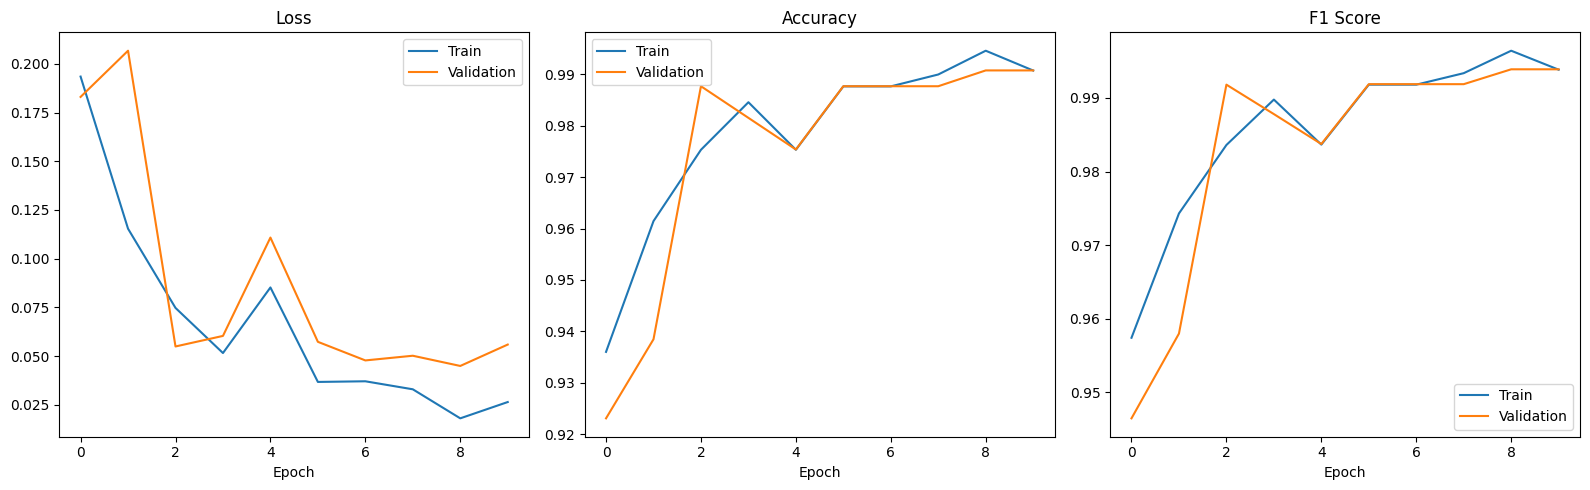

In [ ]:
# Train Final Model with Best Configuration
# Split into train and validation sets
train_df_split, val_df = train_test_split(
    balanced_df, 
    test_size=0.2, 
    stratify=balanced_df['label'],
    random_state=42
)

print(f"Training set: {len(train_df_split)} images")
print(f"Validation set: {len(val_df)} images")

# Get transforms
img_size = 224  # Best size from analysis
train_transforms, val_transforms = get_transforms(img_size=img_size)

# Create datasets
train_dataset = SoilImageDataset(train_df_split, transform=train_transforms)
val_dataset = SoilImageDataset(val_df, transform=val_transforms)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize model with best configuration
model_name = 'resnet18'  # Best model from analysis
model = SoilClassifier(model_name=model_name, pretrained=True)
model = model.to(device)

# Loss function and optimizer with best learning rate
lr = 0.0005  # Best learning rate from analysis
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
num_epochs = 10
model, history = train_model(
    model, train_loader, val_loader, 
    criterion, optimizer, scheduler,
    num_epochs=num_epochs
)

# Plot training history
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['train_f1'], label='Train')
plt.plot(history['val_f1'], label='Validation')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Make predictions on test set

Predicting:   0%|          | 0/31 [00:00<?, ?it/s]

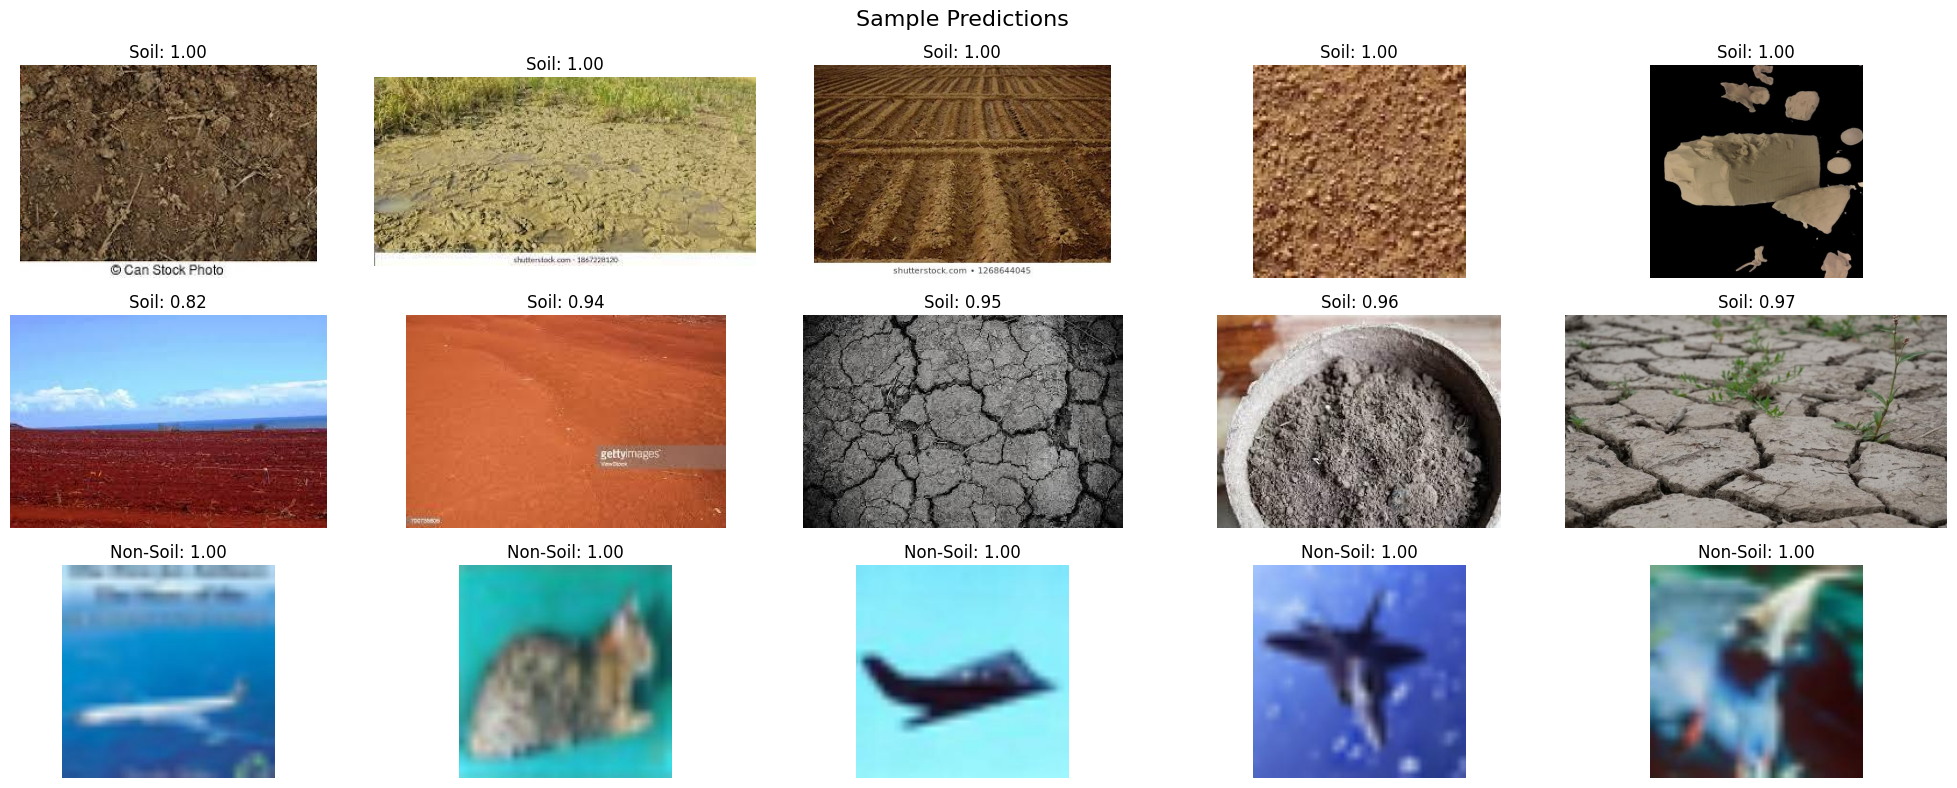

Sample of final submission:
                               image_id  label
0  6595f1266325552489c7d1635fafb88f.jpg      1
1  4b614841803d5448b59e2c6ca74ea664.jpg      1
2  ca30e008692a50638b43d944f46245c8.jpg      1
3  6a9046a219425f7599729be627df1c1a.jpg      1
4  97c1e0276d2d5c2f88dddbc87357611e.jpg      1
5  e432d7988d125c8497d41b7ff223b187.jpg      1
6  0821ca8d9d405e02ab9ebe34ac53d6bd.jpg      1
7  a618ea007b745f56a992eec9f88804f0.jpg      1
8  58e189dd45a156c7934344242452fad4.jpg      1
9  21cdc53949d851b68191e560601e6e0c.jpg      1
Submission saved to 'submission.csv'
Removed temporary directory: /tmp/tmp2qlqplz6


In [ ]:
# Make Predictions on Test Set
def predict_test_set(model, test_df, transforms):
    """Generate predictions for the test set"""
    
    # Create test dataset - note the is_test=True parameter
    test_dataset = SoilImageDataset(test_df, transform=transforms, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    # Set model to evaluation mode
    model.eval()
    
    # Store predictions
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, _ in tqdm(test_loader, desc='Predicting'):
            inputs = inputs.to(device)
            
            # Forward pass
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1 (soil)
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'image_id': test_df['image_id'],
        'label': all_preds,
        'soil_probability': all_probs
    })
    
    # Visualize sample predictions
    plt.figure(figsize=(20, 8))
    
    # Sort by probability for interesting examples
    high_conf_soil = submission_df[submission_df['label'] == 1].sort_values('soil_probability', ascending=False).head(5)
    low_conf_soil = submission_df[submission_df['label'] == 1].sort_values('soil_probability').head(5)
    high_conf_nonsoil = submission_df[submission_df['label'] == 0].sort_values('soil_probability').head(5)
    
    # Display high confidence soil predictions
    for i, (_, row) in enumerate(high_conf_soil.iterrows()):
        img_path = test_df[test_df['image_id'] == row['image_id']]['file_path'].values[0]
        plt.subplot(3, 5, i+1)
        plt.imshow(Image.open(img_path))
        plt.title(f"Soil: {row['soil_probability']:.2f}")
        plt.axis('off')
    
    # Display low confidence soil predictions
    for i, (_, row) in enumerate(low_conf_soil.iterrows()):
        img_path = test_df[test_df['image_id'] == row['image_id']]['file_path'].values[0]
        plt.subplot(3, 5, i+6)
        plt.imshow(Image.open(img_path))
        plt.title(f"Soil: {row['soil_probability']:.2f}")
        plt.axis('off')
    
    # Display high confidence non-soil predictions
    for i, (_, row) in enumerate(high_conf_nonsoil.iterrows()):
        img_path = test_df[test_df['image_id'] == row['image_id']]['file_path'].values[0]
        plt.subplot(3, 5, i+11)
        plt.imshow(Image.open(img_path))
        plt.title(f"Non-Soil: {1-row['soil_probability']:.2f}")
        plt.axis('off')
    
    plt.suptitle("Sample Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return submission_df

# Make predictions
submission_df = predict_test_set(model, test_df, val_transforms)

# Prepare final submission file
final_submission = pd.DataFrame({
    'image_id': submission_df['image_id'],
    'label': submission_df['label']
})

print("Sample of final submission:")
print(final_submission.head(10))

# Save submission
final_submission.to_csv('submission.csv', index=False)
print("Submission saved to 'submission.csv'")

# Clean up temporary directory
shutil.rmtree(temp_dir)
print(f"Removed temporary directory: {temp_dir}")